# Quantum Optimization Training - part 2
## Dealing with constraint using portfolio optimization

## Portfolio Optimization with the Quantum Approximate Optimization Algorithm (QAOA)

### Introduction

Portfolio optimization [[1](#PortfolioWiki)] is the process of allocating a portfolio of financial assets optimally, according to some predetermined goal. Usually, the goal is to maximize the potential return while minimizing the financial risk of the portfolio. One can express this problem as a combinatorial optimization problem like many other real-world problems. In this demo, we'll show how the Quantum Approximate Optimization Algorithm (QAOA) [[2](#QAOA)] can be employed on the Classiq platform to solve the problem of portfolio optimization.

### Modeling the Portfolio Optimization Problem

As a first step, we have to model the problem mathematically. We will use a simple yet powerful model, which captures the essence of portfolio optimization:

- A portfolio is built from a pool of $n$ financial assets, each asset labeled $i \in \{1,\ldots,n\}$.
- Every asset's return is a random variable, with expected value $\mu_i$ and variance $\Sigma_i$ (modeling the financial risk involved in the asset).
- Every two assets $i \neq j$ have covariance $\Sigma_{ij}$ (modeling market correlation between assets).
- Every asset $i$ has a weight $w_i \in D_i = \{0,\ldots,b_i\}$ in the portfolio, with $b_i$ defined as the budget for asset $i$ (modeling the maximum allowed weight of the asset).
- The return vector $\mu$, the covariance matrix $\Sigma$ and the weight vector $w$ are defined naturally from the above (with the domain $D = D_1 \times D_2 \times \ldots \times D_n$ for $w$).

With the above definitions, the total expected return of the portfolio is $\mu^T w$ and the total risk is $w^T \Sigma w$. We'll use a simple difference of the two as our cost function, with the additional constraint that the total sum of assets does not exceed a predefined budget $B$. We note that there are many other possibilities for defining a cost function (e.g. add a scaling factor to the risk/return or even some non-linear relation). For reasons of simplicity we select the model below, and we assume all constants and variables are dimensionless.
Thus, the problem is, given the constant inputs $\mu, \Sigma, D, B$, to find optimal variable $w$ as follows:

$\begin{equation*}
\min_{w \in D}  w^T \Sigma w - \mu^T w,
\end{equation*}$
subject to $\Sigma_{i} w_i \leq B$.

The case presented above is called integer portfolio optimization, since the domains $D_i$ are over the (positive) integers.
Another variation of this problem defines weights over binary domains, and will not be discussed here.


## References

<a id='PortfolioWiki'>[1]</a>: [Portfolio Optimization (Wikipedia)](https://en.wikipedia.org/wiki/Portfolio_optimization)

<a id='QAOA'>[2]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

In [1]:
!pip install classiq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.4/522.4 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 34.8 MB/s eta 0:00:00
  Attempting uninstall: Pyomo
    Found existing installation: Pyomo 6.8.2
    Uninstalling Pyomo-6.8.2:
      Successfully uninstalled Pyomo-6.8.2
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.27.2
    Uninstalling pydantic_core-2.27.2:
      Suc

In [ ]:
from typing import List

import networkx as nx
from classiq import *
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from classiq.execution import ExecutionSession, ExecutionPreferences

#### Finaly, we will add inequality constraints:

$$\begin{equation*}
\min_{w \in D}  w^T \Sigma w - \mu^T w,
\end{equation*}$$
subject to:
$$\Sigma_{i} w_i \leq B$$

**We will do it similarly to the equality constraint but we add slack variable that can take multiple values to make sure $\Sigma_{i} w_i \leq B$**

In this case, we will change the objective function as follows:

$$\begin{equation*}
\min_{w \in D}  w^T \Sigma w - \mu^T w + P * (\Sigma_{i} w_i + slack - B)^2
\end{equation*}$$

Where $P$ is the penalty value you need to define.

# The Portfolio Optimization Problem Parameters

First we define the parameters of the optimization problem, which include the expected return vector, the covariance matrix, the total budget and the asset-specific budgets:

In [ ]:
returns = np.array([3, 4, -1])
# fmt: off
covariances = np.array(
    [
        [ 0.9,  0.5, -0.7],
        [ 0.5,  0.9, -0.2],
        [-0.7, -0.2,  0.9],
    ]
)
# fmt: on
total_budget = 6

## Defining the variables

The number of slack qubits needs to reach to get to the number $B$.

In [ ]:
num_assets = 3

num_qubits_per_asset = 2 # Defines the possible values of choosing each asset.

num_slack = 3

class PortfolioOptimizationVars(QStruct):
    a: QArray[QNum[num_qubits_per_asset], num_assets]
    slack: QNum[num_slack]

### Define the expected return
Define a function that describes $\mu^T w$ where $\mu$ is the `return` vector.

In [ ]:
def expected_return_cost(returns: np.ndarray, w_array: PortfolioOptimizationVars) -> float:
    return sum([w_array.a[i]*returns[i] for i in range(len(returns))])

### Define the risk term
Define a function that describes the risk term in the objective function $w^T \Sigma w$ where $\Sigma$ is the `covariances` matrix.

$$\begin{equation*}
\min_{w \in D}  w^T \Sigma w - \mu^T w + P * (\Sigma_{i} w_i + slack - B)^2
\end{equation*}$$

In [ ]:
def risk_cost(covariances: np.ndarray, w_array: PortfolioOptimizationVars) -> float:
    risk_term =  sum(
        w_array.a[i] * sum(w_array.a[j] * covariances[i][j] for j in range(covariances.shape[0])) for i in range(covariances.shape[0])
    )
    return risk_term

### Define the entire portfolio optimization objective function

Combine the risk term and the expected return functions.
There a a term called return coefficient `return_coeff` that defines how much you prefer certainly over return. Higher values is more risky but can be more profitable.

Later try changing it to see how the result changes.

<details>
<summary>
Answer
</summary>
The function takes two named inputs:

    def expected_return_cost(returns: np.ndarray, w_array: PortfolioOptimizationVars) -> float:
    return sum(returns[i] * w_array.a[i] for i in range(len(returns)))



    def risk_cost(covariances: np.ndarray, w_array: PortfolioOptimizationVars) -> float:
        risk_term =  sum(
            w_array.a[i] * sum(w_array.a[j] * covariances[i][j] for j in range(covariances.shape[0])) for i in range(covariances.shape[0])
        )
        return risk_term
    
    
    def objective_portfolio_inequality(w_array: PortfolioOptimizationVars, returns: np.ndarray, covariances: np.ndarray, return_coeff: float) -> float:
        return risk_cost(covariances, w_array) - \
            return_coeff * expected_return_cost(returns, w_array) + \
            Penalty * (sum(w_array.a[i] for i in range(len(returns))) + w_array.slack - total_budget)**2


</details>

In [ ]:
return_coeff = 10.0

def objective_portfolio_inequality(
    w_array: PortfolioOptimizationVars,
    returns: np.ndarray, covariances: np.ndarray,
    return_coeff: float) -> float:
    # sum(wi)<=6
    return Penalty*((total_budget-sum(w_array.a))-w_array.slack)**2 + risk_cost(covariances, w_array) - return_coeff*expected_return_cost(returns, w_array)


# Build the QAOA circuit

In [ ]:
@qfunc
def mixer_layer(beta: CReal, qba: QArray[QBit]):
    # Your code here
    pass

In [ ]:
NUM_LAYERS = 4

@qfunc
def main(
    params: CArray[CReal, 2 * NUM_LAYERS],
    w_array: Output[PortfolioOptimizationVars]) -> None:

    # Allocating the qubits
    allocate(num_assets*num_qubits_per_asset+num_slack, w_array)
    hadamard_transform()

    #Do not forget the slack qubits#

    # Build the QAOA circuit similarly to the maxcut
    for i in range(NUM_LAYERS):
        phase(
            objective_portfolio_inequality(),  # edge 0-2
            gammas[i],
        )
        apply_to_all(lambda q: RX(betas[i], q), v)

## Synthesizing and visualizing

In [ ]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

## Execution and post processing

For the hybrid execution, we use `ExecutionSession`, which can evaluate the circuit in multiple methods, such as sampling the circuit, giving specific values for the parameters, and evaluating to a specific Hamiltonian, which is very common in chemical applications.

In QAOA, we will use the `estimate_cost` method, which samples the cost function and returns their average cost from all measurements. That helps to optimize easily.

In [ ]:
NUM_SHOTS = 1000

es = ExecutionSession(
    qprog, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)


# Build `initial_params` list of np.array type.
# The gamma values should start from 0 and, in each layer, should approach closer to 1 linearly
# The beta values should start from 1 and in each layer, should approach closer to 0 linearly
# Then unify it to one list so scipy minimize can digest it.
# Your code here

initial_params = initial_qaoa_params(NUM_LAYERS)

## Define a callback function to track the optimization

In [ ]:
# Record the steps of the optimization
intermediate_params = []
objective_values = []

# Define the callback function to store the intermediate steps
def callback(xk):
    intermediate_params.append(xk)

## Define the objective function

In [ ]:
cost_func = lambda state: objective_portfolio_inequality(
    w_array = ...,
    returns = ...,
    covariances = ...,
    return_coeff= ...
)
def estimate_cost_func(params: np.ndarray) -> float:
    objective_value = es.estimate_cost(
        cost_func = ...,
        parameters = {"params": params.tolist()}
    )
    # Your code here
    # Save the result for convergence graph

    return objective_value

## Optimize

In [ ]:
optimization_res = minimize(
    fun = ...,
    x0=...,
    method="COBYLA",
    callback=...,
    options={"maxiter": 10},
)

## Look at the results

In [ ]:
res = es.sample({"params": optimization_res.x.tolist()})

print(f"Optimized parameters: {optimization_res.x.tolist()}")

sorted_counts = sorted(res.parsed_counts, key=lambda pc: objective_portfolio_inequality(pc.state["w_array"],returns = returns, covariances = covariances, return_coeff= return_coeff))

for sampled in sorted_counts:
    w_sample = sampled.state["w_array"]
    print(f"solution={w_sample} probability={sampled.shots/NUM_SHOTS} "
          f"cost={objective_portfolio_inequality(w_array=w_sample,returns = returns, covariances = covariances, return_coeff= return_coeff)}")


## Convergence graph

In [ ]:
plt.plot(objective_values)
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.title("Optimization Progress")

# Solution

Your user code: MPWP-MZHH
If a browser doesn't automatically open, please visit this URL from any trusted device: https://auth.classiq.io/activate?user_code=MPWP-MZHH
Opening: https://platform.classiq.io/circuit/2sc0p6ZxXk494xyiVaR2pYXERhm?version=0.67.0
Optimized parameters: [1.0, 4.141592653589793, 2.5707963267948966, 1.5707963267948966, 3.141592653589793, 0.0]
solution={'a': [2, 3, 0], 'slack': 1} probability=0.002 cost=-162.3
solution={'a': [2, 3, 1], 'slack': 0} probability=0.003 cost=-155.4
solution={'a': [3, 2, 0], 'slack': 1} probability=0.002 cost=-152.3
solution={'a': [3, 3, 1], 'slack': 0} probability=0.001 cost=-148.8
solution={'a': [3, 2, 1], 'slack': 0} probability=0.009 cost=-146.4
solution={'a': [1, 3, 0], 'slack': 2} probability=0.003 cost=-138.0
solution={'a': [2, 3, 0], 'slack': 0} probability=0.002 cost=-131.8
solution={'a': [2, 3, 0], 'slack': 2} probability=0.001 cost=-131.8
solution={'a': [2, 2, 0], 'slack': 2} probability=0.006 cost=-128.8
solution={'a': [3, 2, 

Text(0.5, 1.0, 'Optimization Progress')

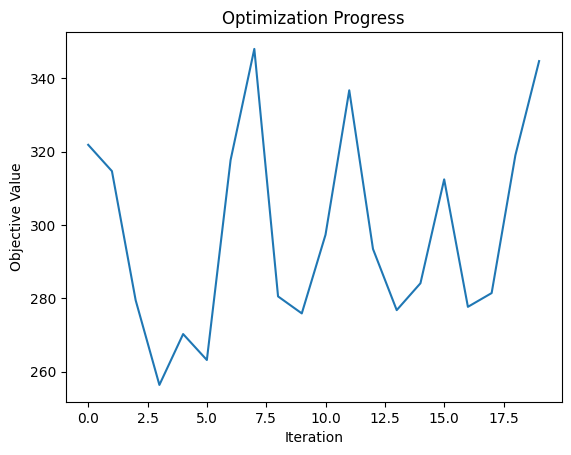

In [3]:
from typing import List

import networkx as nx
from classiq import *
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from classiq.execution import ExecutionSession, ExecutionPreferences

NUM_LAYERS = 3

num_slack = 3

returns = np.array([3, 4, -1])
# fmt: off
covariances = np.array(
    [
        [ 0.9,  0.5, -0.7],
        [ 0.5,  0.9, -0.2],
        [-0.7, -0.2,  0.9],
    ]
)
# fmt: on
total_budget = 6
specific_budgets = 3

return_coeff = 10.0

num_assets = 3

num_qubits_per_asset = 2

Penalty = 30.5

# start with integer variables

class PortfolioOptimizationVars(QStruct):
    a: QArray[QNum[num_qubits_per_asset], num_assets]
    slack: QNum[num_slack]

def expected_return_cost(returns: np.ndarray, w_array: PortfolioOptimizationVars) -> float:
    return sum(returns[i] * w_array.a[i] for i in range(len(returns)))

def risk_cost(covariances: np.ndarray, w_array: PortfolioOptimizationVars) -> float:
    risk_term =  sum(
        w_array.a[i] * sum(w_array.a[j] * covariances[i][j] for j in range(covariances.shape[0])) for i in range(covariances.shape[0])
    )
    return risk_term


def objective_portfolio_inequality(w_array: PortfolioOptimizationVars, returns: np.ndarray, covariances: np.ndarray, return_coeff: float) -> float:
    return risk_cost(covariances, w_array) - \
        return_coeff * expected_return_cost(returns, w_array) + \
        Penalty * (sum(w_array.a[i] for i in range(len(returns))) + w_array.slack - total_budget)**2


@qfunc
def mixer_layer(beta: CReal, qba: QArray[QBit]):
    apply_to_all(lambda q: RX(beta, q), qba)

@qfunc
def main(params: CArray[CReal, 2 * NUM_LAYERS], w_array: Output[PortfolioOptimizationVars]) -> None:
    # allocate(len(returns), w_array)
    allocate(num_qubits_per_asset * num_assets + num_slack, w_array)

    hadamard_transform(w_array)

    repeat(
        count=params.len / 2,
        iteration=lambda i: (
            phase(
                expr= objective_portfolio_inequality(w_array, returns, covariances, return_coeff),
                theta = params[2 * i]
            ),
            mixer_layer(params[2 * i + 1], w_array)
        )
    )

qmod = create_model(main)
authenticate()
qprog = synthesize(qmod)
show(qprog)


NUM_SHOTS = 1000

es = ExecutionSession(
    qprog, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)

def initial_qaoa_params(NUM_LAYERS) -> np.ndarray:
    initial_gammas = math.pi * np.linspace(0, 1, NUM_LAYERS)
    initial_betas = math.pi * np.linspace(1, 0, NUM_LAYERS)

    initial_params = []

    for i in range(NUM_LAYERS):
        initial_params.append(initial_gammas[i])
        initial_params.append(initial_betas[i])

    return np.array(initial_params)

initial_params = initial_qaoa_params(NUM_LAYERS)

# Record the steps of the optimization
intermediate_params = []
objective_values = []

# Define the callback function to store the intermediate steps
def callback(xk):
    intermediate_params.append(xk)

cost_func = lambda state: objective_portfolio_inequality(
    w_array = state["w_array"],
    returns = returns,
    covariances = covariances,
    return_coeff= return_coeff
)

def estimate_cost_func(params: np.ndarray) -> float:
    objective_value = es.estimate_cost(
        cost_func = cost_func,
        parameters = {"params": params.tolist()}
    )
    objective_values.append(objective_value)
    return objective_value


optimization_res = minimize(
    estimate_cost_func,
    x0=initial_params,
    method="COBYLA",
    callback=callback,
    options={"maxiter": 20},
)

res = es.sample({"params": optimization_res.x.tolist()})

print(f"Optimized parameters: {optimization_res.x.tolist()}")

sorted_counts = sorted(res.parsed_counts, key=lambda pc: objective_portfolio_inequality(pc.state["w_array"],returns = returns, covariances = covariances, return_coeff= return_coeff))

for sampled in sorted_counts:
    w = sampled.state["w_array"]
    print(f"solution={w} probability={sampled.shots/NUM_SHOTS} "
          f"cost={objective_portfolio_inequality(w_array=w,returns = returns, covariances = covariances, return_coeff= return_coeff)}")

plt.plot(objective_values)
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.title("Optimization Progress")
